# Introduction

During my Python learning journey, one thing really delights me is how easy it is to use Object Oriented Programming to modulize code, make it easy to test, extend, reuse and maintain. 

Below is a toy example where I created one classifier class to train, tune and explain three classification models (SVM, RandomForest & XGBoost). Thanks to the OOP structure, these tasks can be done in just a few lines if not a one-liner, and it is easy to extend the code to add more functionalities or include more classification algorithms.  

In [1]:
import numpy as np
import pandas as pd
from hyperopt import hp, fmin, space_eval, tpe, rand, Trials
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import shap
import pickle

# Set up

## Define the class for multiple models

In [2]:
# define the class
class Classifier:
    def __init__(self, X, y, model_type, space, n_splits, seed = None):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.seed = seed if seed is not None else np.random.randint(0, 1000)
        self.space = space
        self.model_type = model_type

    def objective(self, space):
        """
        set up the object function for hyperparameter tuning
        """
        if self.model_type == 'svm':
             model = SVC(**space)
        elif self.model_type == 'randomforest':
            model = RandomForestClassifier(**space)
        elif self.model_type == 'xgboost':
            model = XGBClassifier(**space)
        else:
            print('model not available yet')        
        
        cv_scores = cross_val_score(model, self.X, self.y, cv=self.n_splits, scoring='roc_auc', n_jobs=-1)
        return 1 - cv_scores.mean()
    
    def optimize(self, max_evals=100, patience = 10):
        """
        hyperparameter tuning
        """      
        np.random.seed(self.seed)
        best = fmin(fn=self.objective, space=self.space, 
                    algo=tpe.suggest, #rand.suggest
                    max_evals=max_evals, 
                    rstate=np.random.default_rng(self.seed), 
                    trials=trials,
                    early_stop_fn=no_progress_loss(patience))
        
        return best
    
    def test_model(self, best, X_test, y_test):
        """
        define the model using the best parameters
        test it on test data and print out its performance 
        this step can help to identify overfitting
        """
        best_params = space_eval(self.space, best)
        print('best params:', best_params)
        # define the model
        if self.model_type == 'svm':
            model = SVC(**best_params, probability = True)
        elif self.model_type == 'randomforest':
            model = RandomForestClassifier(**best_params)
        elif self.model_type == 'xgboost':
            model = XGBClassifier(**best_params)
        # train the model
        model.fit(self.X, self.y)
        y_pred = model.predict(X_test)
        # print out model performance
        auc = roc_auc_score(y_test, y_pred)
        print('AUC score on test data:', auc)
        
        return model
    
    def explain_model(self, tuned_model, plot_type = None):
        """
        explain the model using shap. Note that the computation of shap values may differ 
        across different classification algorithms.
        """
        if self.model_type == 'randomforest':
            shap_values = shap.TreeExplainer(tuned_model).shap_values(self.X)
            shap.summary_plot(shap_values[1], self.X, plot_type = plot_type)
        elif self.model_type == 'xgboost':
            shap_values = shap.TreeExplainer(tuned_model).shap_values(self.X)
            shap.summary_plot(shap_values, self.X, plot_type = plot_type)
        elif self.model_type == 'svm':
            explainer_svm = shap.Explainer(tuned_model.predict_proba, self.X)
            shap_values_svm = explainer_svm(self.X)
            shap.summary_plot(shap_values_svm[:, :, 1], self.X)        
            
    
    def save_model(self, tuned_model, X, y):
        """
        train the tuned model with all the train data
        print out the performance
        save it for future use
        """
        tuned_model.fit(X, y)
        cv_scores = cross_val_score(tuned_model, X, y, cv=self.n_splits, scoring='roc_auc', n_jobs=-1)
        filename = f'../dev/models/{self.model_type}.pkl'
        pickle.dump(tuned_model, open(filename, 'wb'))
        print(f'The finalized {self.model_type} model saved, its mean cross-validated auc is {np.mean(cv_scores)}.')      
        


## Define the hyperparameter search space for each model

In [3]:
# set up space for hyperparameter tuning
xgb_params = {
    'max_depth':         hp.choice('max_depth',          np.arange(1, 3, 1, dtype=int)),
    #'min_child_weight':  hp.quniform('min_child_weight', 1, 7, 1),
    'gamma':             hp.uniform('gamma', 0, 0.2),
    'subsample':         hp.choice('subsample', [0.6, 0.7, 0.8, 0.9, 1]),
    'colsample_bytree':  hp.choice('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1]),
    'learning_rate':     hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators':      hp.choice('n_estimators',       np.arange(50, 100, 10, dtype =int)),
    'scale_pos_weight':  hp.quniform('scale_pos_weight', 1, 16, 1),
    'reg_alpha':         hp.uniform('reg_alpha', 0.1, 0.2),
    'reg_lambda':        hp.uniform('reg_lambda', 0.1, 0.2),
}

rf_params = {
    "n_estimators":      hp.choice('n_estimators',        np.arange(50, 200, 50, dtype =int)),
    'max_depth':         hp.choice('max_depth',           np.arange(1, 6, 1, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split',   np.arange(2, 10, 1, dtype=int)),
    'min_samples_leaf':  hp.choice('min_samples_leaf',    np.arange(2, 10, 1, dtype=int)),
    'max_features':      hp.choice('max_features', ['log2', 'sqrt', None]),
    'criterion':         hp.choice('criterion', ["gini", "entropy"])
}

svm_params = {
    'kernel':            hp.choice('kernel', ['linear', 'rbf']),
    'C':                 hp.choice('C', [0.1, 1.0, 10])
}


## Prepare the data

In [4]:
# prepare the data (minimal process)
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=1)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model

In [6]:
# baseline model
baseline_model = RandomForestClassifier()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
baseline_auc = roc_auc_score(y_test, y_pred)
print('baseline auc:', baseline_auc)

baseline auc: 0.933531746031746


We can now play with the Classifier defined above. Define, train and tune each of the three classification algorithms in three lines only. Early stop is implemented to save time and guard against overfitting.

In [7]:
%%time 
model_rf = Classifier(X_train, y_train, model_type = 'randomforest', space = rf_params, n_splits = 5, seed=12)
trials = Trials()
best_rf = model_rf.optimize() #default max_evals = 100, patience = 10

 15%|██████▊                                      | 15/100 [00:12<01:09,  1.23trial/s, best loss: 0.008359133126935037]
CPU times: total: 438 ms
Wall time: 12.3 s


In [8]:
%%time 
model_svm = Classifier(X_train, y_train, model_type = 'svm', space = svm_params, n_splits = 5, seed=1)
trials = Trials()
best_svm = model_svm.optimize(max_evals = 150)

 11%|█████▏                                        | 17/150 [00:00<00:04, 33.07trial/s, best loss: 0.00670794633642946]
CPU times: total: 391 ms
Wall time: 518 ms


In [9]:
%%time
model_xgb = Classifier(X_train, y_train, model_type = 'xgboost', space = xgb_params, n_splits = 5, seed = 123)
trials = Trials()
best_xgb = model_xgb.optimize(patience = 9)

 21%|█████████▍                                   | 21/100 [00:05<00:18,  4.20trial/s, best loss: 0.008565531475748123]
CPU times: total: 625 ms
Wall time: 5.02 s


# Test model with test data

Examine the tuned model with test data. Print out the the best hyperparameters selected and the AUC score. 

In [10]:
tuned_model_rf = model_rf.test_model(best_rf, X_test, y_test)

best params: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
AUC score on test data: 0.933531746031746


In [11]:
tuned_model_svm = model_svm.test_model(best_svm, X_test, y_test)

best params: {'C': 1.0, 'kernel': 'rbf'}
AUC score on test data: 0.9692460317460316


In [12]:
tuned_model_xgb = model_xgb.test_model(best_xgb, X_test, y_test)

best params: {'colsample_bytree': 0.7, 'gamma': 0.16244780123471048, 'learning_rate': 0.24356689136041426, 'max_depth': 2, 'n_estimators': 80, 'reg_alpha': 0.1253251670051708, 'reg_lambda': 0.13693804145075056, 'scale_pos_weight': 6.0, 'subsample': 0.7}
AUC score on test data: 0.9404761904761905


# Explain any selected model

The computation and shape of shap values may differ acorss different algorithms. But by setting that up in the class, all explanation is done as a one-liner here. An additional benefit is ease of maintainance: in case of any update in the `shap` packages or as my understanding of shap implementation progress (still learning the rich resources, docs and examples [here](https://shap.readthedocs.io/en/latest/index.html)), we only need to make changes in that one place as well. 

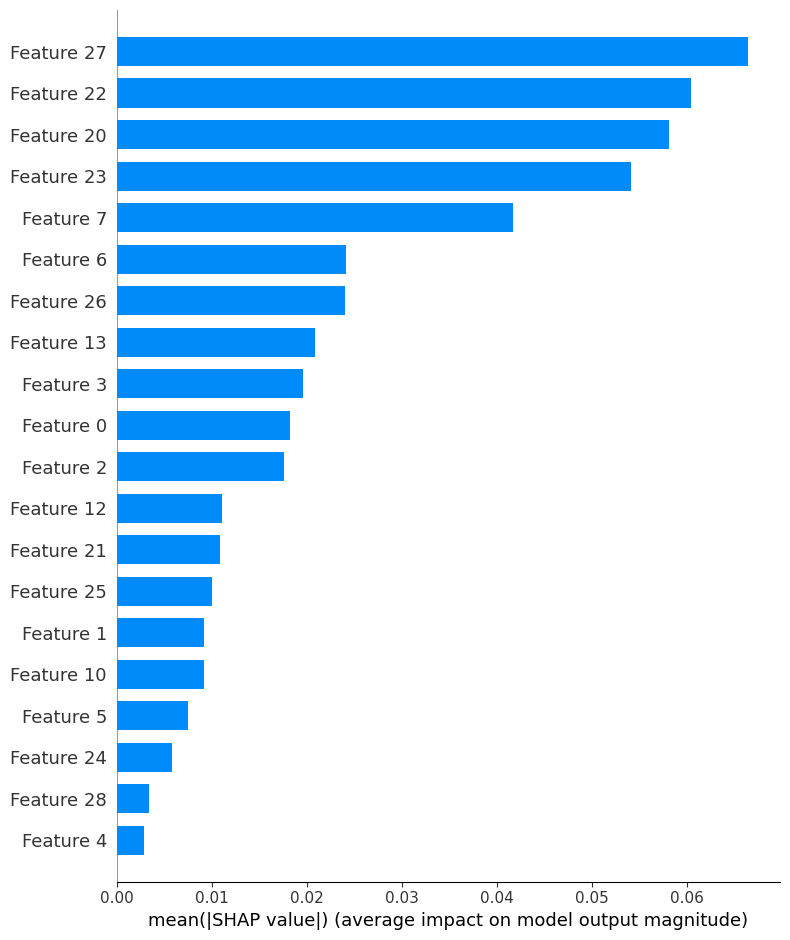

In [13]:
model_rf.explain_model(tuned_model_rf, plot_type = 'bar')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


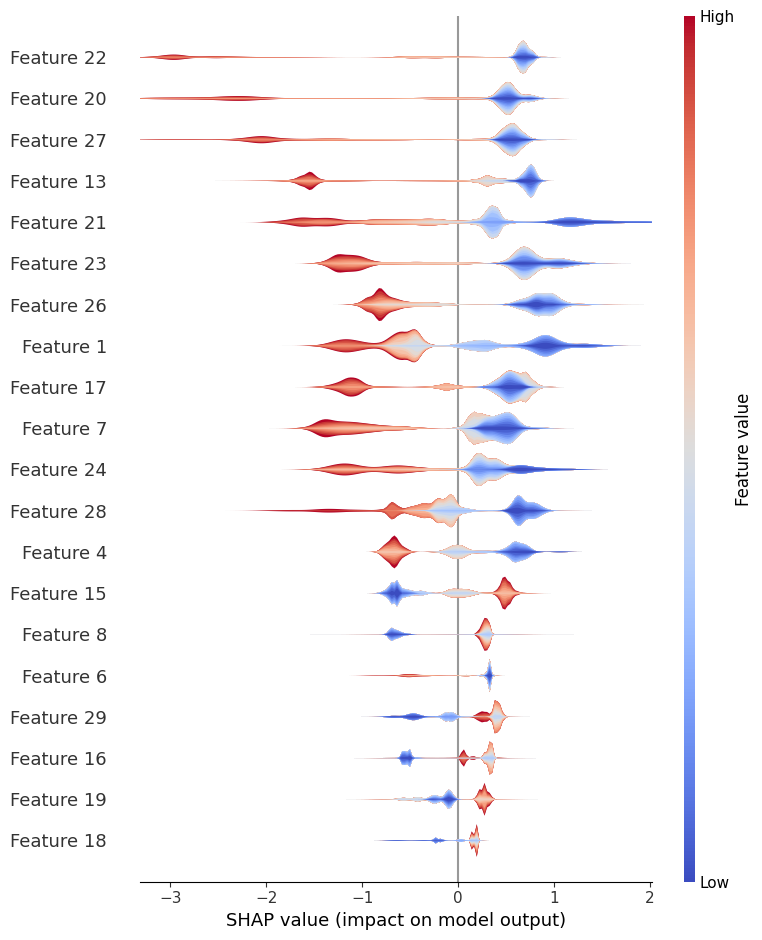

In [14]:
model_xgb.explain_model(tuned_model_xgb, plot_type = 'layered_violin')

Permutation explainer: 456it [08:23,  1.11s/it]                                                                        
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


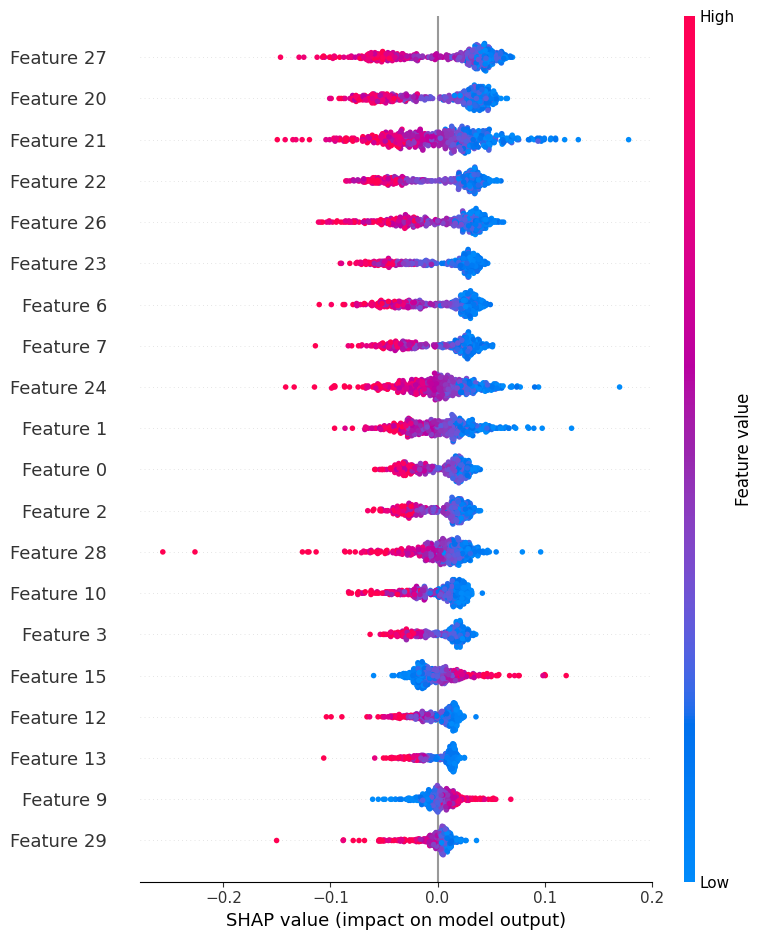

In [15]:
model_svm.explain_model(tuned_model_svm) # default plot

# Save the model

Train the tuned model with all the training data available, then save it for future use on new data. 

In [16]:
model_rf.save_model(tuned_model_rf, data.data, data.target)

The finalized randomforest model saved, its mean cross-validated auc is 0.9925670734137816.


In [17]:
model_xgb.save_model(tuned_model_xgb, data.data, data.target)

The finalized xgboost model saved, its mean cross-validated auc is 0.9929497961065271.


In [18]:
model_svm.save_model(tuned_model_svm, data.data, data.target)

The finalized svm model saved, its mean cross-validated auc is 0.973961923998773.


### Some final notes
If none of the hyperparamters across models has the same name (say if we only have svm and randomforest to test), we could create a params dictionary and just pass the whole nested dictionary when defining the model later (demo code below). 

In [19]:
"""
space = dict()
space['svm_params'] = svm_params
space['rf_params']  = rf_params

# in objective()
model = SVC(**space['svm_params'])
model = RandomForestClassifier(**space['rf_params'])

# when defining the model
model = Classifier(X_train, y_train, model_type= 'randomforest', space=params, n_splits=5, seed=123)

"""

"\nspace = dict()\nspace['svm_params'] = svm_params\nspace['rf_params']  = rf_params\n\n# in objective()\nmodel = SVC(**space['svm_params'])\nmodel = RandomForestClassifier(**space['rf_params'])\n\n# when defining the model\nmodel = Classifier(X_train, y_train, model_type= 'randomforest', space=params, n_splits=5, seed=123)\n\n"